# comparison of accessibility of nucleotides in the sequences

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=3)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')
import matplotlib.pyplot as plt

# Load data

In [2]:
import ShaKer.rna_tools.rna_io as rio

def getdata():
    return rio.get_all_data("../data/RNA16.react","../data/RNA16.dbn")  # {key: rea, seq, stru}

data = getdata()

for k,v in data.items():print k,"\t",  len(v[1])

TRP5 	202
5srRNA 	170
GLYCFN 	205
RNAsep 	154
adenin 	71
Z-CIDGMP-1 	135
R009 	1542
ZHCV 	95
MDLOOP 	80
srRNA 	120
p564 	155
tRNAphe 	76
ZGLY 	198
23sRNA 	2904
ADDRSW 	121
tRNA-asp 	75


# train predict

In [3]:
import ShaKer.simushape as sim
from ShaKer.rna_tools.rnaplfold import rnaplfold

data = getdata()
model  = sim.make_model(data,['23sRNA','R009'])
data.pop("23sRNA")
data.pop("R009")

keys = data.keys()

def get_str(seq):
    for _, data_seq, db in data.values():
        if seq == data_seq:
            return [db]
    print "SHIT"
    
predictions = { k: (data[k][1],sim.predict(model,data[k][1])) for k in keys  }
predictions_str = { k: (data[k][1],sim.predict(model,data[k][1], seq_to_db_function=get_str)) for k in keys  }
acc_shaker = {k: rnaplfold(*predictions[k]) for  k in keys} # a predcition is seq,rea
acc_shaker_str = {k: rnaplfold(*predictions_str[k]) for  k in keys} # a predcition is seq,rea


In [4]:
if False:
    data = getdata()
    keys = data.keys()
    shaker_shape = sim.crosspredict_nfold(data,keys)
    

# real and sukosd based accessibility

In [5]:
from ShaKer.rna_tools.sukosd import sukosd

# generate more for suko so we can pick the median later
acc_suko =  [ {k: rnaplfold(data[k][1], sukosd(data[k][2]) ) for  k in keys} for i in range(5)]
acc_shape =  {k: rnaplfold(data[k][1],data[k][0]) for  k in keys}  
acc_nodata = {k: rnaplfold(data[k][1]) for  k in keys}


acc_theoretical_best = {k: rnaplfold(data[k][1],[1.0 if e =='.' else 0.0 for e in data[k][2]]) for k in keys} ### DOES THIS WORK? 


In [6]:
from scipy.stats import spearmanr as spear

corr = lambda ac1, ac2:[spear(ac1[k], ac2[k])[0] for k in keys]
corr_suko =  [corr(acc , acc_shape) for acc in acc_suko]
corr_suko.sort(key=sum)
corr_suko=corr_suko[2]

corr_shaker =  corr(acc_shaker, acc_shape)
corr_shaker_str =  corr(acc_shaker_str, acc_shape)
corr_nodata =  corr(acc_nodata, acc_shape)
corr_theo = corr(acc_theoretical_best, acc_shape)

# Visualize 

update_title_pos
Assigning font /b'F1' = '/home/ikea/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
Embedding font /home/ikea/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
Writing TrueType font.
update_title_pos
update_title_pos
update_title_pos
Assigning font /b'F1' = '/home/ikea/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
Embedding font /home/ikea/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
Writing TrueType font.
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


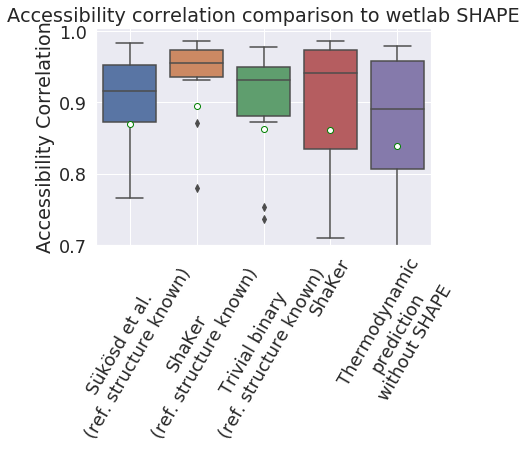

In [45]:
import pandas as pd
import numpy as np
#index= ['Sukosd',"ShaKer+Structure", "known_strucure_max","ShaKer","Thermodynamic"]
#index= [u"Sükösd et al.","ShaKer (real str)", "Paired-Unpaired(real str)","ShaKer","rnaplfold(no SHAPE)"]

index= [u"Sükösd et al.\n(ref. structure known)",
        "ShaKer\n(ref. structure known)", 
        "Trivial binary\n(ref. structure known)",
        "ShaKer",
        "Thermodynamic\nprediction"]

#data2 = [corr_suko, corr_shaker_str,corr_theo,corr_shaker,corr_nodata]

import seaborn as sns
sns.set_context("paper")
sns.set_style('darkgrid')
sns.set(font_scale=1.6)
plt.xticks(rotation=60)

meanpointprops = dict(marker='o', markeredgecolor='green',markerfacecolor='w')

sns.boxplot(data=zzz,meanprops=meanpointprops, showmeans=True)
plt.title("Accessibility correlation comparison to wetlab SHAPE")
plt.grid()
axes = plt.gca()
axes.set_ylim([0.7,1.005])
axes.set_ylabel("Accessibility Correlation")
axes.grid(b=True, which='major', color='w', linewidth=1.0)
plt.savefig("Accessibility.pdf", bbox_inches='tight')

In [41]:
zzz = pd.read_csv("access_PAPER.csv")
del zzz["asd"]
zzz

,Sükösd et al. (ref. structure known),ShaKer (ref. structure known),Trivial binary (ref. structure known),ShaKer,Thermodynamic prediction without SHAPE
0,0.958500,0.978142,0.950267,0.974249,0.975396
1,0.765942,0.780132,0.736296,0.978249,0.978867
2,0.325093,0.294153,0.260131,0.550962,0.520805
3,0.946718,0.956563,0.925426,0.908626,0.847748
4,0.836148,0.966780,0.973729,0.966545,0.877654
5,0.952317,0.957053,0.931686,0.972162,0.978766
6,0.911268,0.871347,0.753561,0.852996,0.905179
7,0.955996,0.978150,0.945245,0.976720,0.948119
8,0.918293,0.975469,0.950318,0.464696,0.550390
9,0.884386,0.954719,0.957856,0.829329,0.793642


In [10]:
data4=pandas.DataFrame(data2, index=index).T
print data4.std(axis=0)
print data4.mean(axis=0)

Sükösd et al.\n(ref. structure known)     0.167025
ShaKer\n(ref. structure known)            0.181262
Trivial binary\n(ref. structure known)    0.188767
ShaKer                                    0.169026
Thermodynamic\nprediction                 0.158267
dtype: float64
Sükösd et al.\n(ref. structure known)     0.869467
ShaKer\n(ref. structure known)            0.894987
Trivial binary\n(ref. structure known)    0.862292
ShaKer                                    0.860941
Thermodynamic\nprediction                 0.838655
dtype: float64


In [33]:
# SAVING REULT
# access_PAPER is also in the repo
#data4.to_csv("access_PAPER.csv",encoding = "utf-8")
!cat access_PAPER.csv

"asd","Sükösd et al.
(ref. structure known)","ShaKer
(ref. structure known)","Trivial binary
(ref. structure known)",ShaKer,"Thermodynamic
prediction"
0,0.9585001207119278,0.9781422555467569,0.9502671543043291,0.974248955179164,0.975395518428428
1,0.7659424794492298,0.7801320952664761,0.7362955250072332,0.9782490282285495,0.978867335082648
2,0.3250929809449484,0.29415343342343153,0.26013103492853423,0.5509624722116991,0.5208048362608126
3,0.9467176621076345,0.956562668661543,0.925426372302691,0.9086262684255476,0.8477480852173506
4,0.8361477734688765,0.9667795836077849,0.9737285648742824,0.9665448103311634,0.8776536919360108
5,0.9523171935545304,0.957053315112905,0.9316856692596315,0.9721621302792667,0.9787658003293115
6,0.9112681970884658,0.8713465845464725,0.7535614186684269,0.8529955207166854,0.9051791713325867
7,0.9559957866640135,0.9781502821860473,0.9452448326198656,0.9767202036391224,0.9481185426706563
8,0.9182926532892828,0.9754687399638634,0.9503180132230846,0.4646962717839349

In [ ]:
plt.xticks(rotation=70)
g=sns.stripplot(data=pandas.DataFrame(data2, index=index).T)
g=sns.boxplot(data=pandas.DataFrame(data2, index=index).T)
plt.title(TITLE)
g.set(ylim=(0, 1))
plt.grid()

In [ ]:
map(lambda x:x.append(np.mean(x)),data2)    
data2 = pandas.DataFrame(data2, columns=keys+['mean'], index=index).T
from tabulate import tabulate
print tabulate(data2, headers="keys", tablefmt="orgtbl")

In [ ]:
print data2.to_latex()

---